
image 1/1 /home/hope/R&D_Pro/HRNet/test.jpg: 480x640 1 BSF, 8.6ms
Speed: 3.3ms preprocess, 8.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)
Person 1:
  Predicted keypoints: [[     2321.4      1637.8]
 [     2990.8      2181.9]]
  Predicted scores:    [    0.99611     0.99514]
----------------------------------------


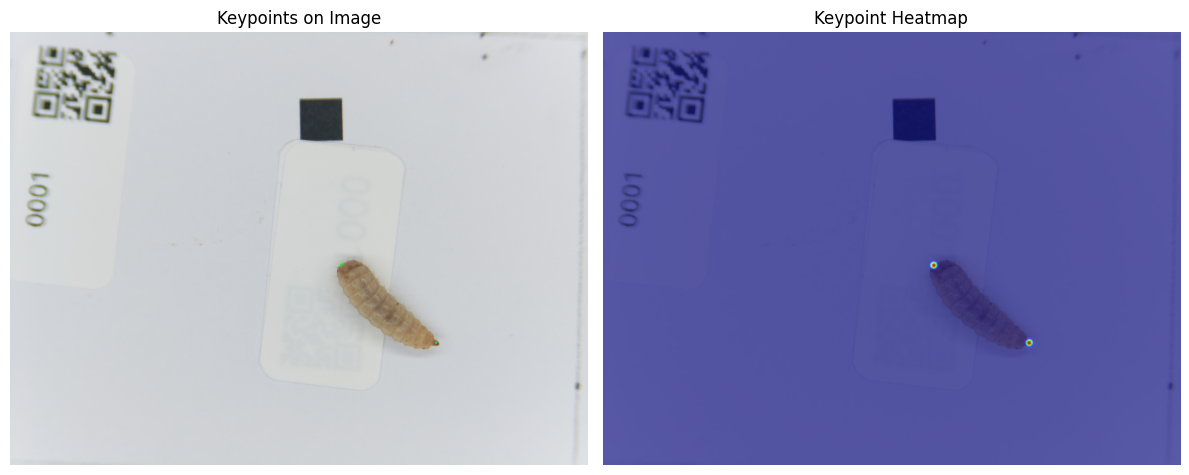

In [15]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 1. 加载模型
model = YOLO("/home/hope/R&D_Pro/HRNet/yolov8/runs/pose/train29/weights/best.pt")

# 2. 图片路径
img_path = "/home/hope/R&D_Pro/HRNet/test.jpg"

# 推理
results = model.predict(img_path, conf=0.25, device=0)
kpts_xy = results[0].keypoints.xy.cpu().numpy()      # 关键点位置 [N, num_kpts, 2]
kpts_conf = results[0].keypoints.conf.cpu().numpy()  # 关键点置信度 [N, num_kpts]

img0 = cv2.imread(img_path)

# 可视化
for idx, (person_kpts, person_confs) in enumerate(zip(kpts_xy, kpts_conf)):
    for i, ((x, y), conf) in enumerate(zip(person_kpts, person_confs)):
        cv2.circle(img0, (int(x), int(y)), 8, (0, 255, 0), -1)
        cv2.putText(img0, f"{i}", (int(x)+3, int(y)-3), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)

# 热力图
heatmap = np.zeros(img0.shape[:2], dtype=np.float32)
for person_kpts in kpts_xy:
    for (x, y) in person_kpts:
        if 0 <= int(x) < heatmap.shape[1] and 0 <= int(y) < heatmap.shape[0]:
            cv2.circle(heatmap, (int(x), int(y)), 20, 1, -1)
heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigmaX=10, sigmaY=10)
heatmap = np.clip(heatmap, 0, 1)

# 打印Predicted keypoints和scores
for idx, (xy, conf) in enumerate(zip(kpts_xy, kpts_conf)):
    print(f"Person {idx+1}:")
    print("  Predicted keypoints:", xy)
    print("  Predicted scores:   ", conf)
    print('-' * 40)

# 显示图片
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.title("Keypoints on Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.title("Keypoint Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()
